# Final Back Test
Full back test doing 5-fold cross validation for 10 different random seed, used as a final performance evaluation after model selection

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from data_process.data_transform_processor import DataTransformProcessor
from models.model_flow import ModelFlow
# from schema.columns_added_filled import LABEL_COL, NUMERICAL_COLS, CATEGORICAL_COLS, LOG_COLS
# from schema.columns_added import LABEL_COL, NUMERICAL_COLS, CATEGORICAL_COLS, LOG_COLS
from schema.columns_original import LABEL_COL, NUMERICAL_COLS, CATEGORICAL_COLS, LOG_COLS
from models.nn_models.dnn import DNN
from lightgbm import LGBMRegressor
import lightgbm
from sklearn.linear_model import ElasticNet
from models.tree_models.lgbm import LGBM
from models.backtest import BackTest
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


# Prepare data

In [2]:
df_all = pd.read_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/df_merged_20170923.csv')

/Users/shuyangdu/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Candidate Data Processors

In [3]:
data_processor_dummy = DataTransformProcessor(
    use_dummy=True, use_scale=True,
    numerical_cols=NUMERICAL_COLS, 
    categorical_cols=CATEGORICAL_COLS,
    log_cols=LOG_COLS, 
    label_col=LABEL_COL,
)
data_processor_tree = DataTransformProcessor(
    numerical_cols=NUMERICAL_COLS, 
    categorical_cols=CATEGORICAL_COLS,
    log_cols=LOG_COLS, 
    label_col=LABEL_COL,
)

## Data preprocess

In [5]:
X_all = data_processor_tree.pre_process(df_all)
y_all = df_all[LABEL_COL].values

In [7]:
X_p = data_processor_tree.fit_transform(X_all)

In [9]:
X_p.shape

(90275, 54)

# Candidate Models

## ElasticNet

In [5]:
model_elt = ElasticNet(alpha=90, l1_ratio=0.85)

## LightGBM

In [10]:
params = {
    'max_bin': 80,
    'learning_rate': 0.0116,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'feature_fraction': 0.94,
    'bagging_fraction': 0.85,
    'bagging_freq': 80,
    'num_leaves': 110,
    'lambda_l2': 86.9,
    'n_estimators': 450,
}

In [11]:
model_lgbm = LGBM(
#     feature_name=data_processor_tree.categorical_cols + data_processor_tree.numerical_cols,
    categorical_feature=data_processor_tree.categorical_col_idx,
    **params
)

## NeuralNetwork

In [8]:
model_dnn = DNN(
    dim_hidden_lst=[30], 
    learning_rate=0.01, 
    decay=0.0001,
    batch_size=128, 
    epochs=5, 
    verbose=0
)

# Back test

In [12]:
model_flow = ModelFlow(model=model_lgbm, data_processor=data_processor_tree)

In [13]:
backtest = BackTest(model_flow=model_flow)

## LightGBM

In [36]:
backtest.full_cv(X_all, y_all)

0.067055145204735878

In [23]:
backtest.single_cv(X_all, y_all)

0.067051519491748077

In [17]:
backtest.full_cv(X_all, y_all)

0.067105600663580456

In [47]:
# check with old values
backtest.full_cv(X_all, y_all)

0.067148169747151862

In [75]:
backtest.single_cv(X_all, y_all)

0.067011907335776305

In [9]:
backtest.single_cv(X_all, y_all)

0.067177496201157746

In [14]:
backtest.single_cv(X_p, y_all)

0.067138754532116832

## ElasticNet

In [10]:
backtest.full_cv(X_all, y_all)

0.068458717051321921

In [24]:
backtest.single_cv(X_all, y_all)

0.068457909738367503

## NeuralNetwork

In [9]:
backtest.full_cv(X_all, y_all)

0.06844671392965937

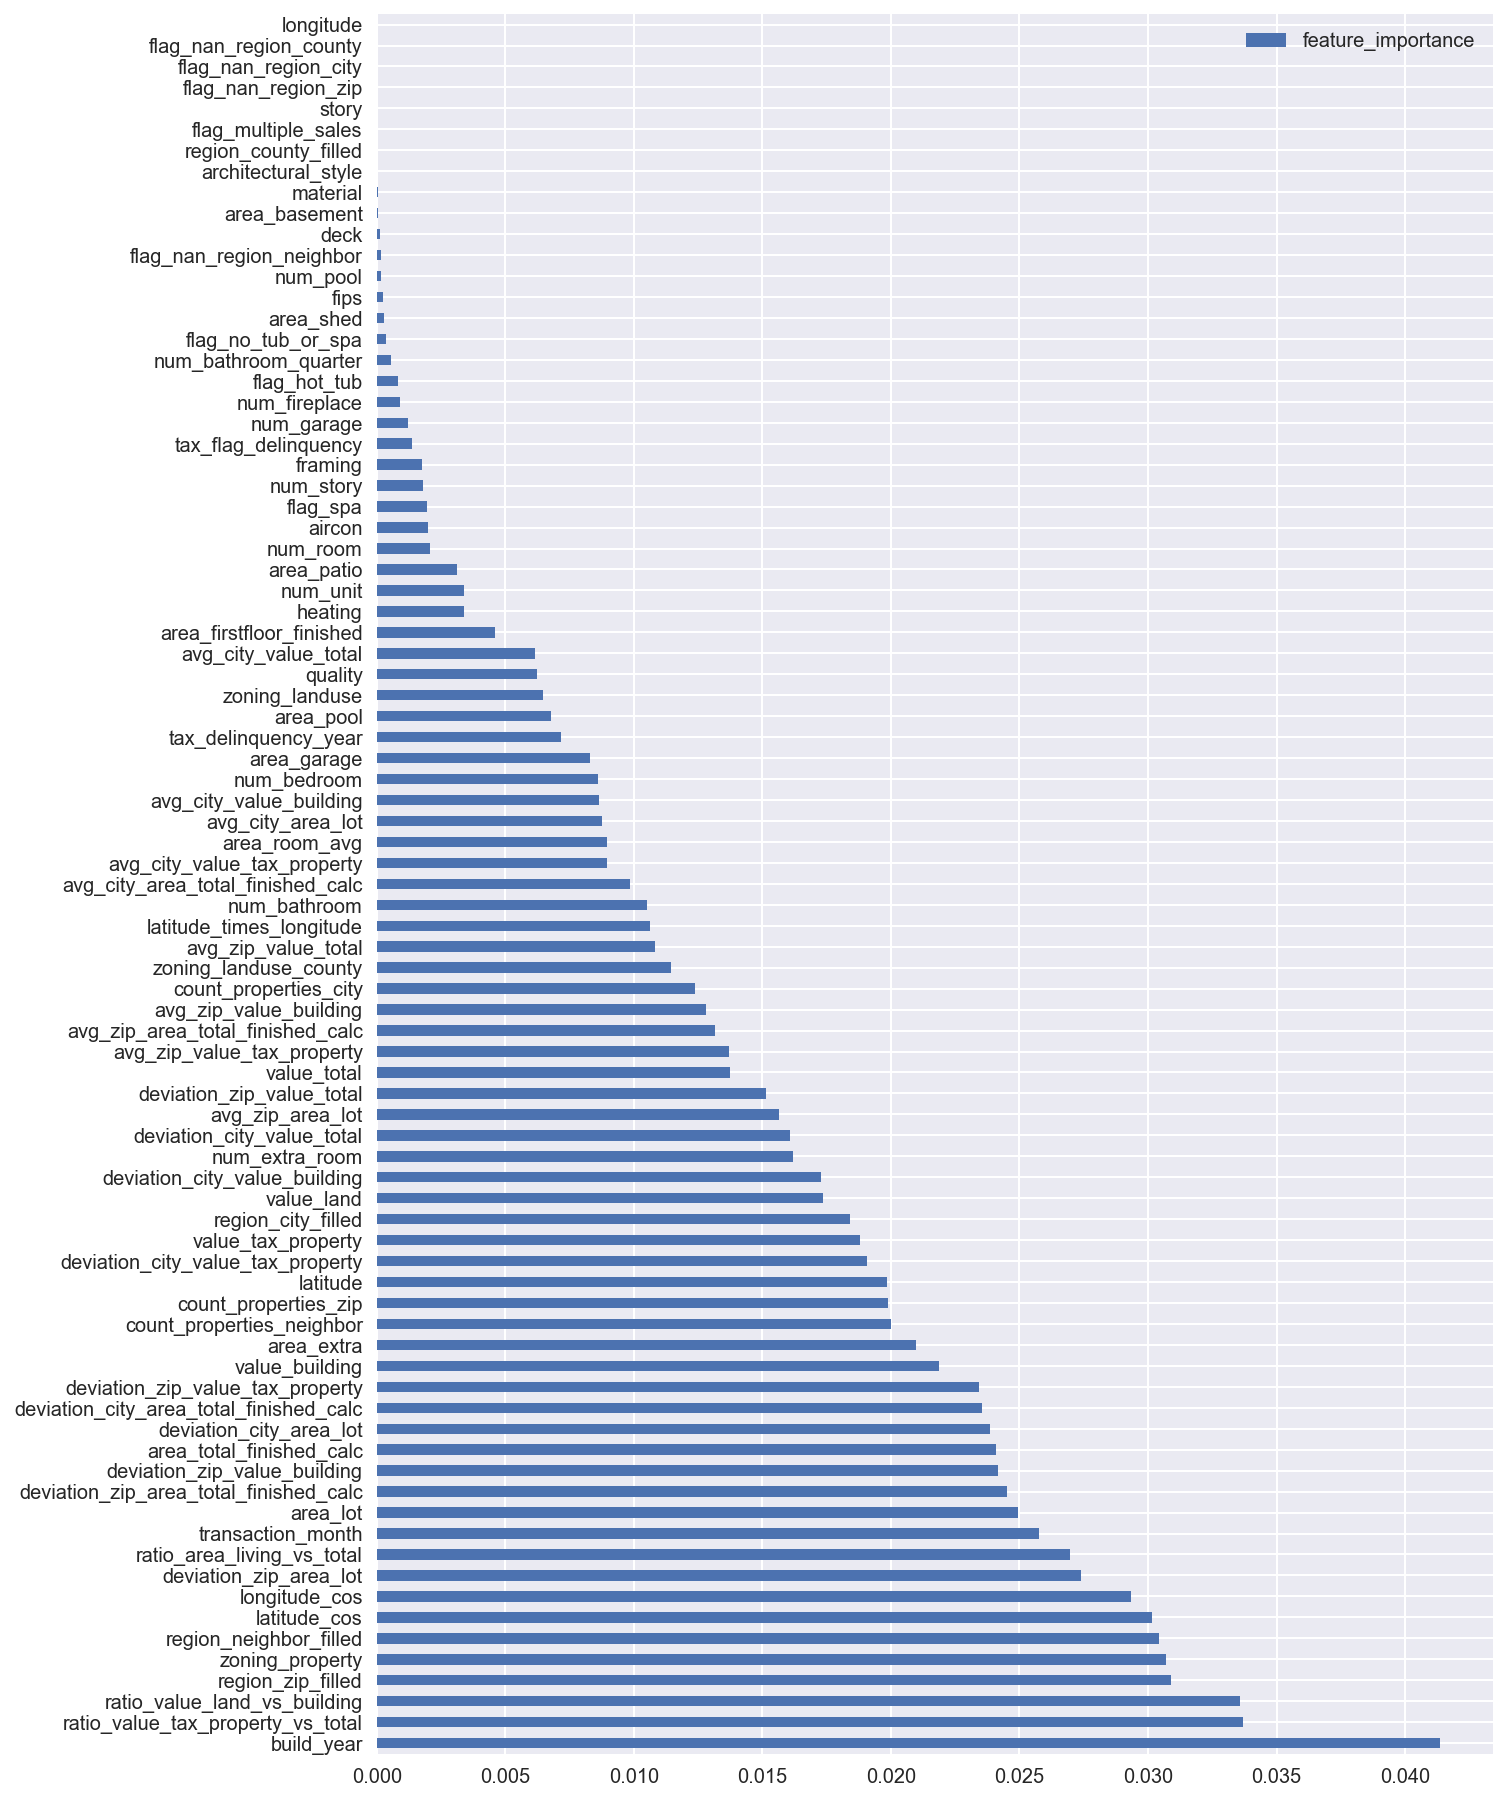

In [36]:
model_flow.feature_importance_plot